In [2]:
# Desktop Testing 
import tensorflow as tf
from pathlib import Path

TFLITE_PATH = Path(r"C:\Users\Ravi Kumar\Desktop\models\tinyml_cnn_int8_fixed.tflite")
print("Exists:", TFLITE_PATH.exists(), "->", TFLITE_PATH)

inter = tf.lite.Interpreter(model_path=str(TFLITE_PATH))
inter.allocate_tensors()


Exists: True -> C:\Users\Ravi Kumar\Desktop\models\tinyml_cnn_int8_fixed.tflite


In [4]:
import numpy as np, tensorflow as tf
from pathlib import Path

TFLITE_PATH = Path(r"C:\Users\Ravi Kumar\Desktop\models\tinyml_cnn_int8_fixed.tflite")  # or tinyml_cnn_int8.tflite

inter = tf.lite.Interpreter(model_path=str(TFLITE_PATH))
inter.allocate_tensors()
inp = inter.get_input_details()[0]
out = inter.get_output_details()[0]

print("INPUT :", inp["dtype"], "quant:", inp["quantization"], "shape:", inp["shape"])
print("OUTPUT:", out["dtype"], "quant:", out["quantization"], "shape:", out["shape"])

def infer_tflite_int8(X_std):  # X_std: (N, WIN, 1) standardized windows (float32)
    s, z = inp["quantization"]
    preds = np.empty((len(X_std),), dtype=np.int64)
    for i in range(len(X_std)):
        x = X_std[i].astype(np.float32).reshape(1, X_std.shape[1], 1)
        xq = np.round(x / (s if s>0 else 1.0) + z).clip(-128,127).astype(np.int8)
        inter.set_tensor(inp["index"], xq)
        inter.invoke()
        y = inter.get_tensor(out["index"])
        preds[i] = y.argmax(-1)[0]
    return preds


INPUT : <class 'numpy.int8'> quant: (0.04188209027051926, -14) shape: [   1 2048    1]
OUTPUT: <class 'numpy.int8'> quant: (0.00390625, -128) shape: [1 4]


In [6]:
# === 1) Imports & paths ===
import os, time
import numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import classification_report

# <-- EDIT THESE if your paths differ
DATA_ROOT  = Path(r"C:\Users\Ravi Kumar\Desktop\TinyML Project\data\DE_12k\npz")
TFLITE_PATH = Path(r"C:\Users\Ravi Kumar\Desktop\models\tinyml_cnn_int8_fixed.tflite")

assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"
assert TFLITE_PATH.exists(), f"TFLITE not found: {TFLITE_PATH}"

# === 2) Load splits ===
def load_split(root, name):
    d = np.load(root / f"{name}.npz")
    return d["X"], d["y"]

X_train, y_train = load_split(DATA_ROOT, "train")
X_val,   y_val   = load_split(DATA_ROOT, "val")
X_test,  y_test  = load_split(DATA_ROOT, "test")

WIN = int(X_test.shape[1])
print("Loaded. WIN =", WIN, "| Test shape:", X_test.shape)

# === 3) Standardize per window + add channel ===
def standardize(X):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-8
    return (X - mu) / sd

X_test_s = standardize(X_test).astype("float32")[..., None]

# === 4) Open TFLite + helper ===
inter = tf.lite.Interpreter(model_path=str(TFLITE_PATH))
inter.allocate_tensors()
inp = inter.get_input_details()[0]
out = inter.get_output_details()[0]
print("INPUT :", inp["dtype"], "quant:", inp["quantization"], "shape:", inp["shape"])
print("OUTPUT:", out["dtype"], "quant:", out["quantization"], "shape:", out["shape"])

def infer_tflite_int8(X_std):  # X_std: (N, WIN, 1) float32, standardized
    s, z = inp["quantization"]
    preds = np.empty((len(X_std),), dtype=np.int64)
    for i in range(len(X_std)):
        x = X_std[i].reshape(1, WIN, 1)  # ensure [1, WIN, 1]
        # Quantize for INT8 input
        xq = np.round(x / (s if s>0 else 1.0) + z).clip(-128,127).astype(np.int8)
        inter.set_tensor(inp["index"], xq)
        inter.invoke()
        y = inter.get_tensor(out["index"])
        preds[i] = y.argmax(-1)[0]
    return preds

# === 5) Parity + latency ===
t0 = time.perf_counter()
y_pred = infer_tflite_int8(X_test_s)
dt = time.perf_counter() - t0
print(f"Desktop TFLite latency ≈ {dt/len(X_test_s)*1e3:.3f} ms/window (rough)")

print(classification_report(
    y_test, y_pred,
    target_names=["Normal","InnerRace","Ball","OuterRace"],
    zero_division=0
))



Loaded. WIN = 2048 | Test shape: (413, 2048)
INPUT : <class 'numpy.int8'> quant: (0.04188209027051926, -14) shape: [   1 2048    1]
OUTPUT: <class 'numpy.int8'> quant: (0.00390625, -128) shape: [1 4]
Desktop TFLite latency ≈ 0.326 ms/window (rough)
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       236
   InnerRace       1.00      1.00      1.00        59
        Ball       1.00      1.00      1.00        59
   OuterRace       1.00      1.00      1.00        59

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



In [10]:
def add_gaussian_noise(X, snr_db):
    # SNR in dB: 10*log10(signal_power/noise_power)
    sig_power = (X**2).mean(axis=1, keepdims=True)
    noise_power = sig_power / (10**(snr_db/10))
    noise = np.random.randn(*X.shape).astype(np.float32) * np.sqrt(noise_power)
    return X + noise

def per_window_standardize(X):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-8
    return (X - mu) / sd

def eval_under(transform, label):
    Xw = X_test.copy()  # raw (N,WIN)
    Xw = transform(Xw)
    Xw_std = per_window_standardize(Xw)[...,None].astype('float32')
    yp = infer_tflite_int8(Xw_std)
    acc = (yp==y_test).mean()
    print(f"{label:20s} acc = {acc:.3f}")

# Prepare raw copies
X_test = X_test_s[...,0]  # back to (N,WIN) float (already standardized, but we’ll recompute after transforms)

# Noise at different SNRs
for snr in [40, 30, 20]:
    eval_under(lambda X: add_gaussian_noise(X, snr), f"Noise @ {snr} dB")

# Amplitude drift (scale)
for scale in [0.8, 1.2, 1.5]:
    eval_under(lambda X, s=scale: X*s, f"Scale x{scale}")

# DC offset drift
for offset in [0.1, -0.1]:
    eval_under(lambda X, b=offset: X+b, f"DC offset {offset:+.1f}")


Noise @ 40 dB        acc = 1.000
Noise @ 30 dB        acc = 1.000
Noise @ 20 dB        acc = 1.000
Scale x0.8           acc = 1.000
Scale x1.2           acc = 1.000
Scale x1.5           acc = 1.000
DC offset +0.1       acc = 1.000
DC offset -0.1       acc = 1.000


In [11]:
from pathlib import Path
import scipy.io as sio
import time

MAT_PATH = Path(r"data/DE_12k/load_0_rpm1797/outer_race_6/OR021@6_0.mat")  # pick any .mat you have
WIN = X_test_s.shape[1]
STEP = 512   # 75% overlap, like train; try 2048 for no overlap

def load_de_signal_from_mat(path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in d.keys() if not k.startswith("__")]
    de_keys = [k for k in keys if "DE" in k.upper()] + keys
    for k in de_keys:
        arr = np.asarray(d[k]).reshape(-1)
        if arr.ndim==1 and arr.size>1000:
            return arr.astype(np.float32)
    raise RuntimeError("No DE signal found")

def standardize_window(w):
    m = w.mean(); s = w.std() + 1e-8
    return (w - m) / s

sig = load_de_signal_from_mat(MAT_PATH)
print("Signal len:", len(sig))

labels = ['Normal','InnerRace','Ball','OuterRace']

for start in range(0, len(sig)-WIN+1, STEP):
    w = sig[start:start+WIN]
    w_std = standardize_window(w).astype('float32').reshape(1, WIN, 1)
    pred = infer_tflite_int8(w_std)[0]
    print(f"t={start/WIN:6.1f}  pred={pred} ({labels[pred]})")
    time.sleep(0.05)  # ~20 Hz


Signal len: 121991
t=   0.0  pred=3 (OuterRace)
t=   0.2  pred=3 (OuterRace)
t=   0.5  pred=3 (OuterRace)
t=   0.8  pred=3 (OuterRace)
t=   1.0  pred=3 (OuterRace)
t=   1.2  pred=3 (OuterRace)
t=   1.5  pred=3 (OuterRace)
t=   1.8  pred=3 (OuterRace)
t=   2.0  pred=3 (OuterRace)
t=   2.2  pred=3 (OuterRace)
t=   2.5  pred=3 (OuterRace)
t=   2.8  pred=3 (OuterRace)
t=   3.0  pred=3 (OuterRace)
t=   3.2  pred=3 (OuterRace)
t=   3.5  pred=3 (OuterRace)
t=   3.8  pred=3 (OuterRace)
t=   4.0  pred=3 (OuterRace)
t=   4.2  pred=3 (OuterRace)
t=   4.5  pred=3 (OuterRace)
t=   4.8  pred=3 (OuterRace)
t=   5.0  pred=3 (OuterRace)
t=   5.2  pred=3 (OuterRace)
t=   5.5  pred=3 (OuterRace)
t=   5.8  pred=3 (OuterRace)
t=   6.0  pred=3 (OuterRace)
t=   6.2  pred=3 (OuterRace)
t=   6.5  pred=3 (OuterRace)
t=   6.8  pred=3 (OuterRace)
t=   7.0  pred=3 (OuterRace)
t=   7.2  pred=3 (OuterRace)
t=   7.5  pred=3 (OuterRace)
t=   7.8  pred=3 (OuterRace)
t=   8.0  pred=3 (OuterRace)
t=   8.2  pred=3 (OuterR

In [12]:
import numpy as np, time
from pathlib import Path
import scipy.io as sio
import tensorflow as tf
from collections import deque

# ---- paths & model ----
MAT_PATH = Path(r"data/DE_12k/load_0_rpm1797/outer_race_6/OR021@6_0.mat")  # try swapping to Normal/Ball/IR files too
TFLITE_PATH = Path(r"C:\Users\Ravi Kumar\Desktop\models\tinyml_cnn_int8_fixed.tflite")
FS_HZ = 12000         # sampling rate (CWRU 12k)
WIN   = 2048          # window length used in training
STEP  = 512           # hop; use 2048 for no overlap
LABELS = ['Normal','InnerRace','Ball','OuterRace']

# ---- load TFLite ----
inter = tf.lite.Interpreter(model_path=str(TFLITE_PATH))
inter.allocate_tensors()
inp = inter.get_input_details()[0]
out = inter.get_output_details()[0]
in_scale, in_zero = inp["quantization"]
out_scale, out_zero = out["quantization"]

def load_de_signal_from_mat(path: Path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in d.keys() if not k.startswith("__")]
    de_keys = [k for k in keys if "DE" in k.upper()] + keys
    for k in de_keys:
        arr = np.asarray(d[k]).reshape(-1)
        if arr.ndim == 1 and arr.size > 1000:
            return arr.astype(np.float32)
    raise RuntimeError("No DE signal found")

def standardize(w):
    m = w.mean(); s = w.std() + 1e-8
    return (w - m) / s

def infer_one(window_std):
    """window_std: (WIN,) float32 standardized."""
    x = window_std.reshape(1, WIN, 1)
    # quantize to int8 for TFLite
    xq = np.round(x / (in_scale if in_scale>0 else 1.0) + in_zero).clip(-128,127).astype(np.int8)
    inter.set_tensor(inp["index"], xq)
    inter.invoke()
    yq = inter.get_tensor(out["index"])[0]                  # int8 logits/probs
    # dequantize to probability (softmax output is quantized)
    probs = np.clip((yq.astype(np.int32) - out_zero) * out_scale, 0.0, 1.0)
    pred = int(np.argmax(probs))
    conf = float(probs[pred])
    return pred, conf, probs

def stream_file(path: Path, step=STEP, smooth_k=5, conf_floor=0.0):
    sig = load_de_signal_from_mat(path)
    print("Signal len:", len(sig))
    # simple majority smoothing over last K frames
    hist = deque(maxlen=smooth_k)
    for start in range(0, len(sig)-WIN+1, step):
        t_sec = start / FS_HZ
        w_std = standardize(sig[start:start+WIN])
        pred, conf, probs = infer_one(w_std)

        hist.append(pred)
        smoothed = max(set(hist), key=hist.count) if hist else pred

        # optional confidence gate
        shown = smoothed if conf >= conf_floor else -1  # -1 means "low confidence"
        label = LABELS[shown] if shown >= 0 else "LowConf"

        print(f"t={t_sec:6.2f}s  pred={pred} ({LABELS[pred]:9s})  "
              f"conf={conf:5.2f}  smoothed={smoothed} ({label})")
        time.sleep(0.05)  # ~20 Hz UI pacing

# ---- run stream ----
stream_file(MAT_PATH, step=STEP, smooth_k=5, conf_floor=0.0)


Signal len: 121991
t=  0.00s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.04s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.09s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.13s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.17s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.21s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.26s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.30s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.34s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.38s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.43s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.47s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.51s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.55s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  0.60s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (Ou

t=  5.29s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.33s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.38s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.42s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.46s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.50s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.55s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.59s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.63s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.67s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.72s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.76s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.80s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.85s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.89s  pred=3 (OuterRace)  conf= 1.00  smoothed=3 (OuterRace)
t=  5.93s 

In [13]:
# Majority label over entire file
counts = np.bincount([infer_one(standardize(load_de_signal_from_mat(MAT_PATH)[i:i+WIN]))[0]
                      for i in range(0, len(load_de_signal_from_mat(MAT_PATH))-WIN+1, STEP)], minlength=4)
print("Counts:", counts, "| Majority:", LABELS[int(np.argmax(counts))])


Counts: [  0   0   0 235] | Majority: OuterRace


In [14]:
from pathlib import Path
import numpy as np, scipy.io as sio, tensorflow as tf

LABELS = ['Normal','InnerRace','Ball','OuterRace']
WIN, STEP, FS_HZ = 2048, 512, 12000

# Use your already-created interpreter:
# inter, inp, out, in_scale, in_zero, out_scale, out_zero

def load_de_signal_from_mat(path: Path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in d.keys() if not k.startswith("__")]
    de_keys = [k for k in keys if "DE" in k.upper()] + keys
    for k in de_keys:
        arr = np.asarray(d[k]).reshape(-1)
        if arr.ndim == 1 and arr.size > 1000:
            return arr.astype(np.float32)
    raise RuntimeError("No DE signal found")

def standardize(w):
    m = w.mean(); s = w.std() + 1e-8
    return (w - m) / s

def infer_one(window_std):
    x = window_std.reshape(1, WIN, 1)
    xq = np.round(x / (in_scale if in_scale>0 else 1.0) + in_zero).clip(-128,127).astype(np.int8)
    inter.set_tensor(inp["index"], xq)
    inter.invoke()
    yq = inter.get_tensor(out["index"])[0]
    probs = np.clip((yq.astype(np.int32) - out_zero) * out_scale, 0.0, 1.0)
    return int(np.argmax(probs)), float(probs.max())

def majority_for_file(mat_path: Path, step=STEP):
    sig = load_de_signal_from_mat(mat_path)
    preds = []
    for start in range(0, len(sig)-WIN+1, step):
        w = standardize(sig[start:start+WIN])
        p, _ = infer_one(w)
        preds.append(p)
    counts = np.bincount(preds, minlength=4)
    maj = int(np.argmax(counts))
    return counts, maj

# EXAMPLE paths – swap these to your actual files:
files_to_check = [
    Path(r"data/DE_12k/load_0_rpm1797/normal/97.mat"),
    Path(r"data/DE_12k/load_0_rpm1797/inner_race/IR021_0.mat"),
    Path(r"data/DE_12k/load_0_rpm1797/ball/B021_0.mat"),
    Path(r"data/DE_12k/load_0_rpm1797/outer_race_6/OR021@6_0.mat"),
]
for p in files_to_check:
    c, maj = majority_for_file(p)
    print(p.name, "-> counts:", c.tolist(), "| majority:", LABELS[maj])


97.mat -> counts: [473, 0, 0, 0] | majority: Normal
IR021_0.mat -> counts: [0, 233, 0, 0] | majority: InnerRace
B021_0.mat -> counts: [0, 0, 236, 0] | majority: Ball
OR021@6_0.mat -> counts: [0, 0, 0, 235] | majority: OuterRace


In [15]:
import pandas as pd
from pathlib import Path
import numpy as np

LABEL_MAP = {"Normal":0,"InnerRace":1,"Ball":2,"OuterRace":3}
META_PATH = Path(r"data/DE_12k/metadata.csv")
meta = pd.read_csv(META_PATH, keep_default_na=False)
meta = meta[meta["label"].isin(LABEL_MAP.keys())].copy()

def eval_file_row(row, step=2048):  # use no overlap for a strict test
    path = Path(row["filepath"])
    true_y = LABEL_MAP[row["label"]]
    counts, maj = majority_for_file(path, step=step)
    correct = int(maj == true_y)
    return pd.Series({
        "filepath": str(path),
        "label_true": row["label"],
        "label_pred": LABELS[maj],
        "pred_counts": counts.tolist(),
        "correct": correct
    })

results = meta.apply(eval_file_row, axis=1)
acc_file_level = results["correct"].mean()
print(f"Per-file majority accuracy: {acc_file_level:.3f}")

# Show mistakes (if any)
errors = results[results["correct"]==0]
print("Errors:", len(errors))
display(errors.head(10))


Per-file majority accuracy: 1.000
Errors: 0


,filepath,label_true,label_pred,pred_counts,correct


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       828
   InnerRace       1.00      1.00      1.00       237
        Ball       1.00      1.00      1.00       236
   OuterRace       1.00      1.00      1.00       236

    accuracy                           1.00      1537
   macro avg       1.00      1.00      1.00      1537
weighted avg       1.00      1.00      1.00      1537



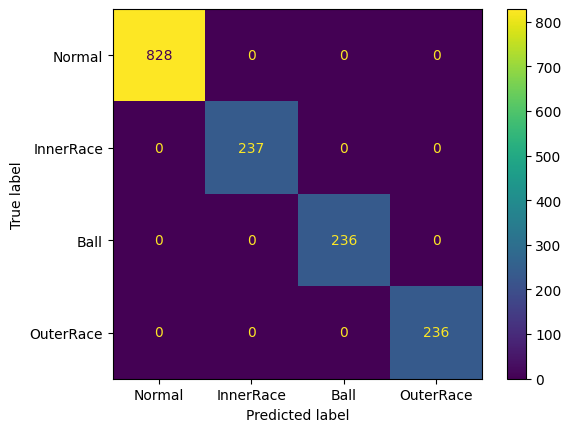

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true_all, y_pred_all = [], []
for _, row in meta.iterrows():
    y_true = LABEL_MAP[row["label"]]
    sig = load_de_signal_from_mat(Path(row["filepath"]))
    for start in range(0, len(sig)-WIN+1, 2048):  # no overlap on eval
        w = standardize(sig[start:start+WIN])
        p, _ = infer_one(w)
        y_pred_all.append(p)
        y_true_all.append(y_true)

y_true_all, y_pred_all = np.array(y_true_all), np.array(y_pred_all)
print(classification_report(y_true_all, y_pred_all, target_names=LABELS, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_true_all, y_pred_all, display_labels=LABELS)
plt.show()


In [17]:
from collections import deque

CONF_TH = 0.6
SMOOTH_K = 5

def majority_with_conf(mat_path, step=2048, conf_th=CONF_TH, k=SMOOTH_K):
    sig = load_de_signal_from_mat(mat_path)
    hist = deque(maxlen=k)
    timeline = []
    for start in range(0, len(sig)-WIN+1, step):
        w = standardize(sig[start:start+WIN])
        pred, conf = infer_one(w)
        label = pred if conf >= conf_th else -1  # -1 = LowConf
        hist.append(label if label>=0 else pred) # smooth over valid preds
        smoothed = max(set(hist), key=hist.count) if hist else pred
        t_sec = start/FS_HZ
        timeline.append((t_sec, pred, conf, smoothed))
    return timeline

# Example usage:
tl = majority_with_conf(files_to_check[-1], step=2048, conf_th=0.6, k=5)
print("First 10:", tl[:10])


First 10: [(0.0, 3, 0.99609375, 3), (0.17066666666666666, 3, 0.99609375, 3), (0.3413333333333333, 3, 0.99609375, 3), (0.512, 3, 0.99609375, 3), (0.6826666666666666, 3, 0.99609375, 3), (0.8533333333333334, 3, 0.99609375, 3), (1.024, 3, 0.99609375, 3), (1.1946666666666668, 3, 0.99609375, 3), (1.3653333333333333, 3, 0.99609375, 3), (1.536, 3, 0.99609375, 3)]


In [18]:
# === File-level results (majority vote per .mat) + images for LinkedIn ===
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---- EDIT THESE PATHS ----
META_PATH   = Path(r"C:\Users\Ravi Kumar\Desktop\TinyML Project\data\DE_12k\metadata.csv")
TFLITE_PATH = Path(r"C:\Users\Ravi Kumar\Desktop\models\tinyml_cnn_int8_fixed.tflite")
OUT_DIR     = Path(r"C:\Users\Ravi Kumar\Desktop\models\linkedin_reports")
# --------------------------

OUT_DIR.mkdir(parents=True, exist_ok=True)

LABELS    = ['Normal','InnerRace','Ball','OuterRace']
LABEL_MAP = {"Normal":0,"InnerRace":1,"Ball":2,"OuterRace":3}
WIN  = 2048         # window length used in training
STEP = 2048         # no overlap for strict eval (matches what you'll do on-device)
FS_HZ = 12000       # CWRU 12k

# ---- Load interpreter (INT8 or float; both supported) ----
inter = tf.lite.Interpreter(model_path=str(TFLITE_PATH))
inter.allocate_tensors()
inp = inter.get_input_details()[0]
out = inter.get_output_details()[0]
in_scale, in_zero   = inp["quantization"]
out_scale, out_zero = out["quantization"]
is_int8_in  = (inp["dtype"]  in (np.int8, np.uint8))
is_int8_out = (out["dtype"] in (np.int8, np.uint8))
print("INPUT :", inp["dtype"], inp["shape"], "quant:", inp["quantization"])
print("OUTPUT:", out["dtype"], out["shape"], "quant:", out["quantization"])

# ---- Helpers ----
def load_de_signal_from_mat(path: Path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in d.keys() if not k.startswith("__")]
    de_keys = [k for k in keys if "DE" in k.upper()] + keys
    for k in de_keys:
        arr = np.asarray(d[k]).reshape(-1)
        if arr.ndim == 1 and arr.size > 1000:
            return arr.astype(np.float32)
    raise RuntimeError(f"No DE signal found in {path}")

def standardize(w):
    m = w.mean(); s = w.std() + 1e-8
    return (w - m) / s

def infer_one(window_std):
    x = window_std.astype(np.float32).reshape(1, WIN, 1)
    if is_int8_in:
        xq = np.round(x / (in_scale if in_scale>0 else 1.0) + in_zero).clip(-128,127).astype(np.int8)
        inter.set_tensor(inp["index"], xq)
    else:
        inter.set_tensor(inp["index"], x)
    inter.invoke()
    y = inter.get_tensor(out["index"])[0]
    if is_int8_out:
        probs = np.clip((y.astype(np.int32) - out_zero) * out_scale, 0.0, 1.0)
    else:
        probs = y.astype(np.float32)
    pred = int(np.argmax(probs))
    conf = float(probs[pred])
    return pred, conf

# ---- Load metadata & filter to 4 classes ----
meta = pd.read_csv(META_PATH, keep_default_na=False)
meta = meta[meta["label"].isin(LABEL_MAP.keys())].copy()

# ---- Evaluate per file (majority vote) ----
rows = []
y_true_all, y_pred_all = [], []
for _, r in meta.iterrows():
    pth = Path(r["filepath"])
    true_y = LABEL_MAP[r["label"]]
    sig = load_de_signal_from_mat(pth)
    preds, confs = [], []
    for start in range(0, len(sig)-WIN+1, STEP):
        w = standardize(sig[start:start+WIN])
        p, c = infer_one(w)
        preds.append(p); confs.append(c)
    counts = np.bincount(preds, minlength=len(LABELS))
    maj = int(np.argmax(counts))
    rows.append({
        "file": pth.name,
        "load_hp": r.get("load_hp",""),
        "rpm": r.get("rpm",""),
        "orientation": r.get("orientation",""),
        "fault_diameter_in": r.get("fault_diameter_in",""),
        "label_true": LABELS[true_y],
        "label_pred": LABELS[maj],
        "correct": int(maj==true_y),
        "windows": int(len(preds)),
        "pred_counts": counts.tolist(),
        "avg_confidence": float(np.mean(confs))
    })
    y_true_all.append(true_y); y_pred_all.append(maj)

df = pd.DataFrame(rows)
df.to_csv(OUT_DIR / "file_level_results.csv", index=False)
print("Saved CSV:", OUT_DIR / "file_level_results.csv")

# ---- Per-class (file-level) accuracy bar ----
acc_per_class = df.groupby("label_true")["correct"].mean().reindex(LABELS).fillna(0.0)
plt.figure(figsize=(6,3))
acc_per_class.plot(kind="bar")
plt.ylim(0,1.05); plt.ylabel("Accuracy")
plt.title("Per-file Accuracy by Class (Majority Vote)")
plt.tight_layout()
bar_path = OUT_DIR / "per_file_accuracy_by_class.png"
plt.savefig(bar_path, dpi=180); plt.close()
print("Saved:", bar_path)

# ---- File-level confusion matrix (true vs majority) ----
cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(len(LABELS))))
fig, ax = plt.subplots(figsize=(4.8,4.4))
ConfusionMatrixDisplay(cm, display_labels=LABELS).plot(ax=ax, colorbar=False)
plt.title("Per-file Confusion Matrix (Majority Vote)")
plt.tight_layout()
cm_path = OUT_DIR / "per_file_confusion_matrix.png"
plt.savefig(cm_path, dpi=180); plt.close()
print("Saved:", cm_path)

# ---- Pretty table image for LinkedIn (limited rows; use multiple pages if needed) ----
def df_to_table_image(df_small, path, title="File-level Results (Majority Vote)"):
    fig, ax = plt.subplots(figsize=(10, 0.5 + 0.4*len(df_small)))  # height scales with rows
    ax.axis('off')
    tbl = ax.table(cellText=df_small.values,
                   colLabels=df_small.columns,
                   loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)
    ax.set_title(title, pad=10)
    plt.tight_layout()
    plt.savefig(path, dpi=220)
    plt.close(fig)

cols = ["file","label_true","label_pred","correct","windows","avg_confidence","pred_counts","load_hp","rpm","orientation","fault_diameter_in"]
df_disp = df[cols].copy()
df_disp["correct"] = df_disp["correct"].map({1:"✓",0:"×"})
df_disp["avg_confidence"] = df_disp["avg_confidence"].map(lambda x: f"{x:.2f}")

# If you have many rows, split into pages of 18 for readability
page_size = 18
pages = max(1, int(np.ceil(len(df_disp)/page_size)))
table_paths = []
for i in range(pages):
    chunk = df_disp.iloc[i*page_size:(i+1)*page_size]
    p = OUT_DIR / f"file_level_results_page{i+1}.png"
    df_to_table_image(chunk, p, title=f"File-level Results (Page {i+1}/{pages})")
    table_paths.append(p)
    print("Saved table:", p)

print("\nAll done!")
print("Attach these to LinkedIn:")
print(" -", OUT_DIR / "per_file_confusion_matrix.png")
print(" -", OUT_DIR / "per_file_accuracy_by_class.png")
for p in table_paths:
    print(" -", p)
print("Raw CSV:", OUT_DIR / "file_level_results.csv")


INPUT : <class 'numpy.int8'> [   1 2048    1] quant: (0.04188209027051926, -14)
OUTPUT: <class 'numpy.int8'> [1 4] quant: (0.00390625, -128)
Saved CSV: C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\file_level_results.csv
Saved: C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\per_file_accuracy_by_class.png
Saved: C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\per_file_confusion_matrix.png
Saved table: C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\file_level_results_page1.png

All done!
Attach these to LinkedIn:
 - C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\per_file_confusion_matrix.png
 - C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\per_file_accuracy_by_class.png
 - C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\file_level_results_page1.png
Raw CSV: C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\file_level_results.csv


In [19]:
from pathlib import Path
import numpy as np, scipy.io as sio, matplotlib.pyplot as plt, tensorflow as tf

# --- EDIT THESE ---
MAT_PATH   = Path(r"data\DE_12k\load_0_rpm1797\outer_race_6\OR021@6_0.mat")  # pick any file
TFLITE_PATH= Path(r"C:\Users\Ravi Kumar\Desktop\models\tinyml_cnn_int8_fixed.tflite")
SAVE_TO    = Path(r"C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\before_after_real.png")
FS_HZ, WIN, STEP = 12000, 2048, 512
LABELS = ['Normal','InnerRace','Ball','OuterRace']
# ------------------

SAVE_TO.parent.mkdir(parents=True, exist_ok=True)

# Load model
inter = tf.lite.Interpreter(model_path=str(TFLITE_PATH))
inter.allocate_tensors()
inp = inter.get_input_details()[0]; out = inter.get_output_details()[0]
in_scale, in_zero   = inp['quantization']
out_scale, out_zero = out['quantization']
is_int8_in  = inp['dtype']  in (np.int8, np.uint8)
is_int8_out = out['dtype'] in (np.int8, np.uint8)

def load_de_signal_from_mat(path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in d.keys() if not k.startswith("__")]
    de_keys = [k for k in keys if "DE" in k.upper()] + keys
    for k in de_keys:
        arr = np.asarray(d[k]).reshape(-1)
        if arr.ndim == 1 and arr.size > 1000:
            return arr.astype(np.float32)
    raise RuntimeError("No DE signal found")

def standardize(w):
    m = w.mean(); s = w.std() + 1e-8
    return (w - m) / s

def infer_one(window_std):
    x = window_std.astype(np.float32).reshape(1, WIN, 1)
    if is_int8_in:
        xq = np.round(x / (in_scale if in_scale>0 else 1.0) + in_zero).clip(-128,127).astype(np.int8)
        inter.set_tensor(inp['index'], xq)
    else:
        inter.set_tensor(inp['index'], x)
    inter.invoke()
    y = inter.get_tensor(out['index'])[0]
    probs = ((y.astype(np.int32) - out_zero) * out_scale).astype(np.float32) if is_int8_out else y.astype(np.float32)
    pred = int(np.argmax(probs)); conf = float(probs[pred])
    return pred, conf

sig = load_de_signal_from_mat(MAT_PATH)
N = (len(sig)-WIN)//STEP + 1
times_sec = (np.arange(N) * STEP) / FS_HZ
preds = np.zeros(N, dtype=int)
for i, start in enumerate(range(0, len(sig)-WIN+1, STEP)):
    w = standardize(sig[start:start+WIN])
    preds[i], _ = infer_one(w)

# Build figure
sec_view = 2.5
n_view = int(sec_view*FS_HZ)
t = np.arange(len(sig)) / FS_HZ

fig, axes = plt.subplots(2,1, figsize=(10,6), gridspec_kw={"height_ratios":[2,1]})
axes[0].plot(t[:n_view], sig[:n_view], lw=1.0)
axes[0].set_title("Raw Vibration Signal (snippet)"); axes[0].set_ylabel("Amplitude (g)")
axes[0].grid(True, alpha=0.2)

axes[1].step(times_sec, preds, where="post")
axes[1].set_yticks(range(4)); axes[1].set_yticklabels(LABELS)
axes[1].set_xlabel("Time (s)"); axes[1].set_ylabel("Predicted Class")
axes[1].set_title("Streaming Inference Timeline (Majority per window)")
axes[1].grid(True, axis="x", alpha=0.2)

plt.tight_layout(); plt.savefig(SAVE_TO, dpi=180); plt.close()
print("Saved:", SAVE_TO)


Saved: C:\Users\Ravi Kumar\Desktop\models\linkedin_reports\before_after_real.png
